# Optimización ED para el volúmen de una polea

### Caracteristicas de la polea
- 40 Kg de carga
- Material AISI 1020
- Límite de elasticidad del material 200, 000 N/mm2

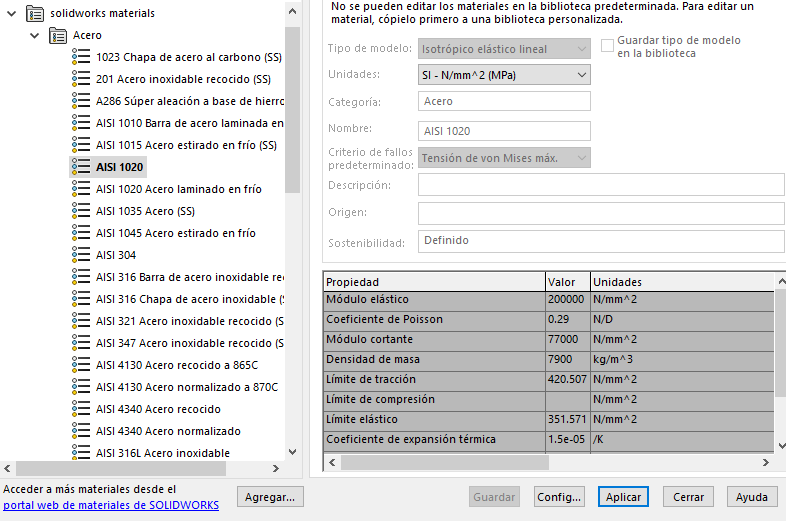

- Fabricación de acuerdo con las medidas de D1, D2, Ancho y Radio de la garganta

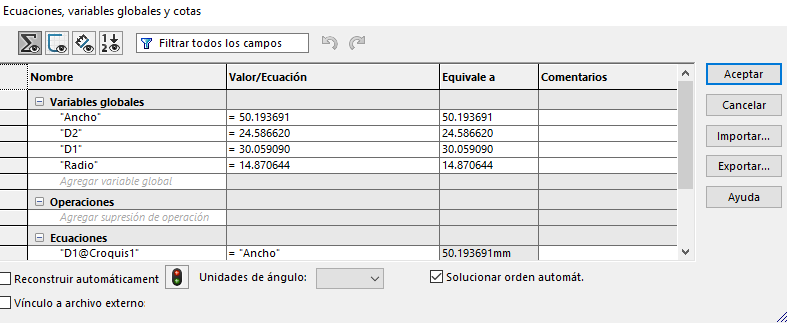
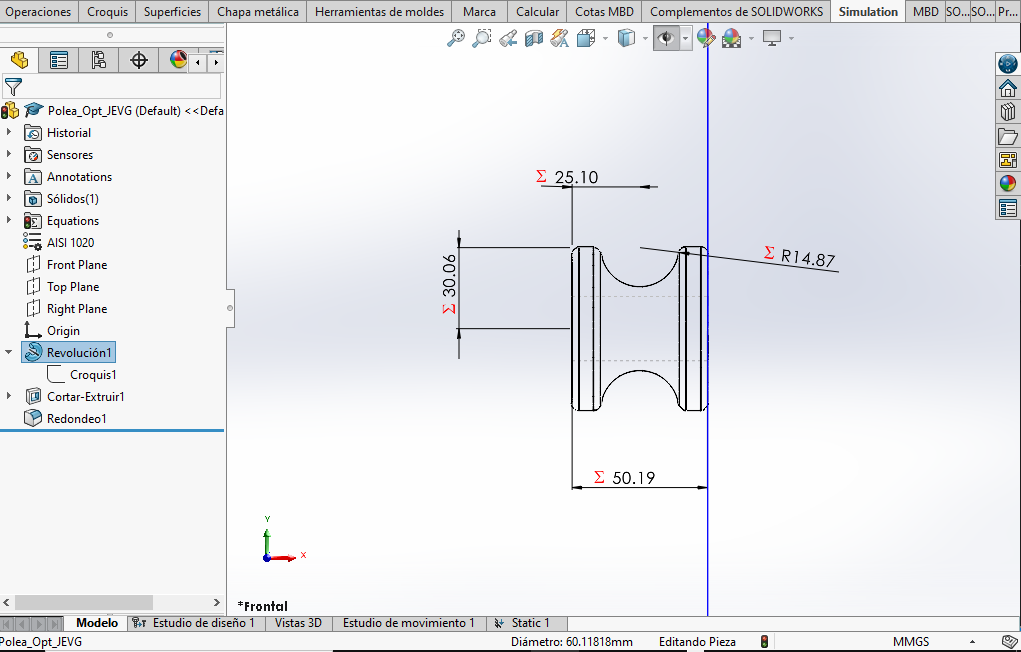
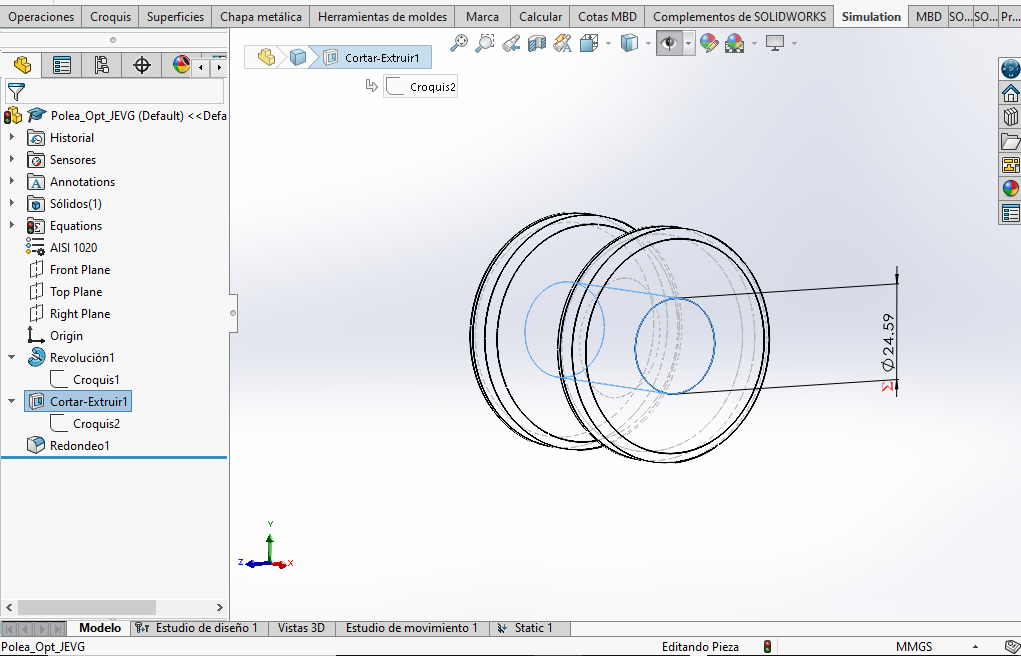

In [2]:
import numpy as np

# Función objetivo y restricciones para la polea
def polea_evaluate(ind, P, sigma_max, E):
    # Variables del individuo (genotipo)
    R, r, H, r_ranura = ind
    
    # Cálculo del volumen del cilindro principal
    V_principal = np.pi * R**2 * H
    
    # Cálculo del volumen del agujero central
    V_interno = np.pi * r**2 * H
    
    # Cálculo del volumen de una ranura (h_ranura es igual a H)
    V_ranura = (0.5 * np.pi * r_ranura**2) * H
    
    # Volumen total de las ranuras (hay dos ranuras)
    V_ranuras = 2 * V_ranura
    
    # Volumen total de la polea
    V_total = V_principal - V_interno - V_ranuras
    
    # Función objetivo (minimizar volumen)
    FO = V_total  # Minimizar el volumen
    
    # Cálculos de propiedades geométricas y mecánicas
    M_inercia = (np.pi / 32) * (R**4 - r**4)  # Momento de inercia de la sección transversal
    E_flector = (P * R / 2) / M_inercia  # Esfuerzo flector en el punto más crítico
    A_corte = np.pi * (R**2 - r**2) / 4  # Área de corte
    E_cortante = P / A_corte  # Esfuerzo cortante
    
    # Restricciones de desigualdad
    G = np.zeros(4)
    G[0] = E_flector - sigma_max
    G[1] = E_cortante - sigma_max
    G[2] = r_ranura - (r / 2)  # El radio de la ranura debe ser menor que la mitad de r
    G[3] = r - (R / 2)  # El radio interno debe ser menor que la mitad del radio externo
    
    # Penalización por violación de restricciones
    penalty = np.sum(np.maximum(G, 0) / 100)  # Penalización por restricciones %
    
    return FO, penalty, E_flector

# Algoritmo de Evolución Diferencial con seguimiento de iteraciones y mejores soluciones al final
def differential_evolution(func, bounds, args, popsize=30, its=200, CR=0.8, F=0.5):
    np.random.seed(42)  # Establecer una semilla fija para reproducibilidad
    D = len(bounds)
    pop = np.random.rand(popsize, D)
    for i in range(D):
        pop[:, i] = bounds[i][0] + pop[:, i] * (bounds[i][1] - bounds[i][0])
    
    pop_scores = np.zeros(popsize)
    penalties = np.zeros(popsize)
    flectors = np.zeros(popsize)
    for i in range(popsize):
        pop_scores[i], penalties[i], flectors[i] = func(pop[i], *args)
    
    for it in range(its):
        for i in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != i]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F * (b - c), 0, 1)
            cross_points = np.random.rand(D) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, D)] = True
            trial = np.where(cross_points, mutant, pop[i])
            trial_denorm = bounds[:, 0] + trial * (bounds[:, 1] - bounds[:, 0])
            trial_denorm = np.clip(trial_denorm, bounds[:, 0], bounds[:, 1])
            score, penalty, flector = func(trial_denorm, *args)
            if (score < pop_scores[i]) and (penalty <= 0):
                pop[i], pop_scores[i], penalties[i], flectors[i] = trial_denorm, score, penalty, flector
            elif (penalties[i] > 0) and (penalty < penalties[i]):
                pop[i], pop_scores[i], penalties[i], flectors[i] = trial_denorm, score, penalty, flector
        
        # Imprimir iteración y resultados de la población
        print(f"Iteración {it+1}:")
        for j in range(popsize):
            print(f"  Individuo {j+1}: {pop[j]} con volumen {pop_scores[j]}, penalización {penalties[j]} y esfuerzo flector {flectors[j]}")
        best_idx = np.argmin(pop_scores)
        print(f"  Mejor resultado hasta ahora: {pop[best_idx]} con volumen {pop_scores[best_idx]}, penalización {penalties[best_idx]} y esfuerzo flector {flectors[best_idx]}\n")
    
    # Obtener las 5 mejores soluciones
    sorted_indices = np.argsort(pop_scores)
    top_5_indices = sorted_indices[:5]
    
    print("Las 5 mejores soluciones:")
    for i in top_5_indices:
        print(f"  Solución {i+1}: {pop[i]} con volumen {pop_scores[i]}, penalización {penalties[i]} y esfuerzo flector {flectors[i]}")
    
    best_idx = np.argmin(pop_scores)
    return pop[best_idx], pop_scores[best_idx], flectors[best_idx]

# Parámetros del problema
P = 40 * 9.81  # Fuerza aplicada (peso de 40 kg convertido a Newtons)
sigma_max = 200e6  # Esfuerzo máximo permitido (200 MPa)
E = 200e9  # Módulo de Young para AISI 1020 (200 GPa)

# Límites para las variables de diseño
bounds = np.array([[30, 40],  # R (radio externo del cilindro)
                   [20, 25],  # r (radio interno del agujero)
                   [50, 75],  # H (altura total del cilindro)
                   [5, 15]])  # r_ranura (radio de la ranura semicircular)

# Optimización
result, score, flector = differential_evolution(polea_evaluate, bounds, args=(P, sigma_max, E))
print("Resultado óptimo:", result)
print("Volumen mínimo de la polea:", score)
print("Esfuerzo flector correspondiente:", flector)


Iteración 1:
  Individuo 1: [40. 25. 75. 15.] con volumen 176714.58676442585, penalización 0.07500000000000001 y esfuerzo flector 0.03684889499355919
  Individuo 2: [40. 25. 75. 15.] con volumen 176714.58676442585, penalización 0.07500000000000001 y esfuerzo flector 0.03684889499355919
  Individuo 3: [40. 25. 75. 15.] con volumen 176714.58676442585, penalización 0.07500000000000001 y esfuerzo flector 0.03684889499355919
  Individuo 4: [38.32442641 21.06169555 54.54562418  6.8340451 ] con volumen 167669.45779495087, penalización 0.01899482349389274 y esfuerzo flector 0.03906712120880283
  Individuo 5: [33.04242243 22.62378216 60.79862547  7.9122914 ] con volumen 98818.44082515436, penalización 0.06102570943363503 y esfuerzo flector 0.07100063146088967
  Individuo 6: [36.11852895 20.6974693  57.30361621  8.66361843] con volumen 144218.5533834343, penalización 0.026382048296483128 y esfuerzo flector 0.047540357097907944
  Individuo 7: [34.56069984 23.92587981 54.99184455 10.14234438] con 

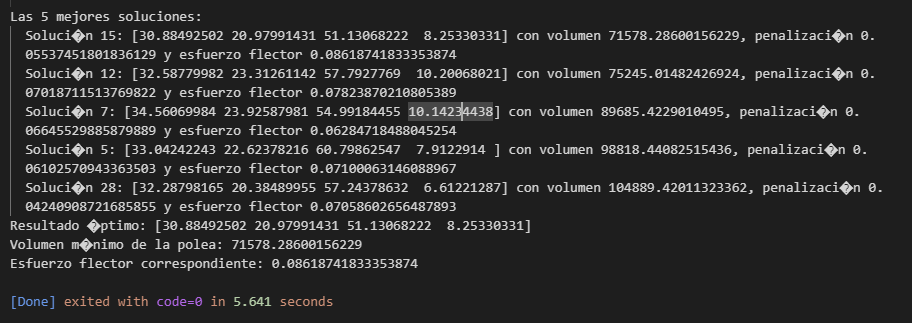

# Comprobación usando el optimizador de SolidWorks


### Análisis estático para verificar que se cumpla la resitencia a la carga
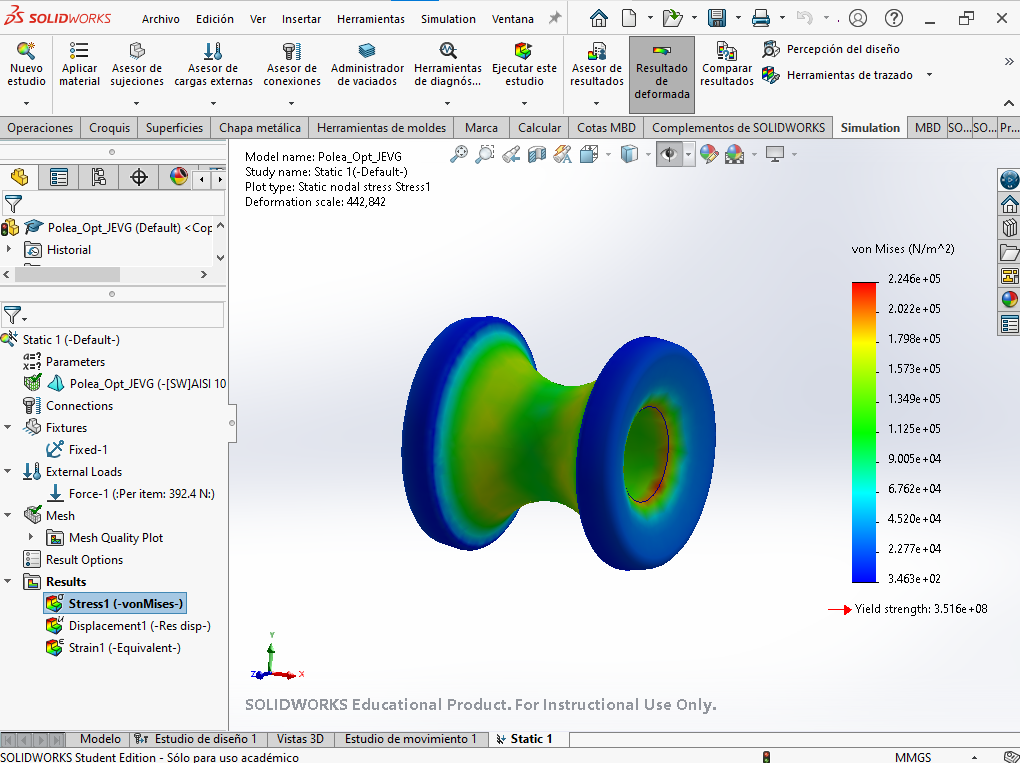

### definición de los parámetros: variables, restricciones y objetivo
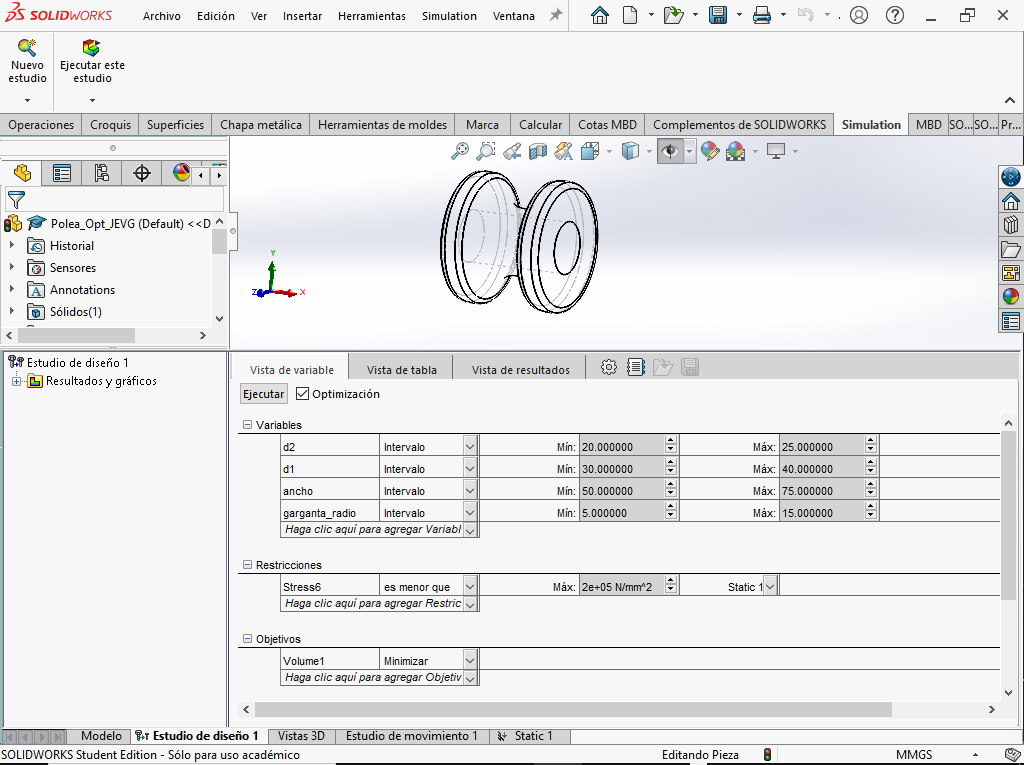


# RESULTAADO
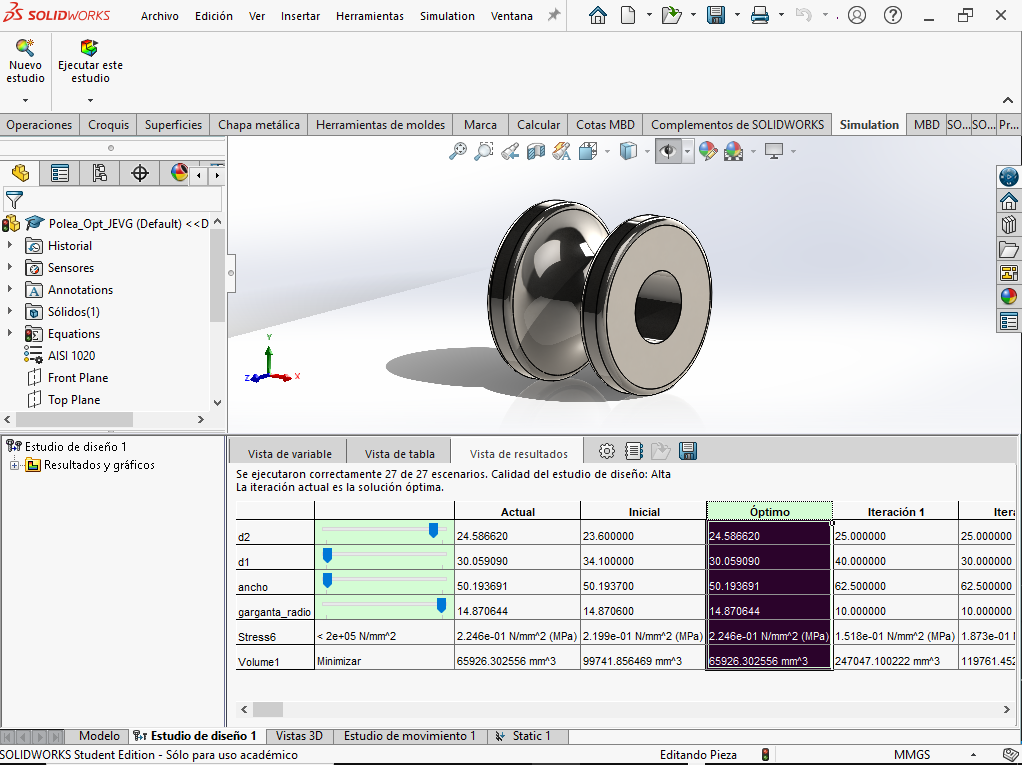

# ANALISIS DE RESULTADOS
### Comparación de Resultados

| Parámetro             | SolidWorks             | Python (Mejor Solución)     |
|-----------------------|------------------------|-----------------------------|
| D1     | 30.059090 mm           | 30.88492502 mm              |
| D2    | 24.586620 mm           | 20.97991431 mm              |
| Altura - Ancho (H)           | 50.193691 mm           | 51.13068222 mm              |
| Radio de Ranura (r_ranura) | 14.870644 mm       | 8.25330331 mm               |
| Esfuerzo Flector      | 0.2246 N/mm² (MPa)     | 0.08618741833353874 N/mm² (MPa)        |
| Volumen               | 65926.302556 mm³       | 71578.28600156229 mm³       |

### Análisis de Resultados

Los resultados obtenidos en SolidWorks y Python muestran algunas diferencias en los parámetros de diseño y en las métricas de rendimiento. A continuación se detallan las observaciones y posibles causas de estas diferencias:

#### - Volumen Total:

SolidWorks: 65926.302556 mm³
Python: 71578.28600156229 mm³

El volumen calculado en Python es mayor que el obtenido en SolidWorks. Esta diferencia puede deberse a las variaciones en los parámetros geométricos como el diámetro D2 y el radio de la ranura.

#### - Diámetros:

-D1: Los diámetros externos son bastante similares entre SolidWorks y Python, lo que sugiere una buena concordancia en este parámetro.
-D2: Hay una diferencia significativa en el diámetro interno, con Python generando un valor menor. Esto afecta directamente el volumen y la distribución del material en la polea.


#### - Altura (H):

La altura de la polea es casi igual en ambos resultados, lo que indica que este parámetro se ha mantenido constante en ambos casos, contribuyendo a una comparación más directa de otros factores.

#### - Radio de Ranura (r_ranura):

El radio de la ranura en los resultados de Python es considerablemente menor que en SolidWorks. Este factor también puede contribuir a la diferencia en el volumen total, ya que un radio de ranura menor reduce el volumen de material removido.

#### - Esfuerzo Flector:

SolidWorks: 0.2246 N/mm² (MPa)
Python: 0.08618741833353874 N/mm² (MPa)

El esfuerzo flector calculado en Python es significativamente menor que en SolidWorks. Esto podría sugerir que el diseño generado por Python es menos propenso a deformaciones bajo carga, aunque también puede indicar que las restricciones en Python permiten un diseño con mayor rigidez.

## Conclusiones
La comparación entre los resultados de SolidWorks y Python revela que, aunque existen diferencias en los valores específicos de los parámetros, el método de optimización utilizado en Python ofrece una buena aproximación a los resultados de SolidWorks. Las diferencias en los diámetros y el radio de la ranura son las principales causas de la variación en el volumen total. El menor esfuerzo flector en Python sugiere un diseño potencialmente más rígido.

Para mejorar la concordancia entre ambos métodos, se podrían ajustar las restricciones y parámetros de diseño en Python para reflejar más fielmente las condiciones y criterios utilizados en SolidWorks. A pesar de las diferencias, los resultados obtenidos mediante la optimización en Python proporcionan una solución viable y efectiva, lo que demuestra la utilidad de los algoritmos evolutivos para problemas de diseño y optimización en ingeniería.